# Análisis de Regresión Lineal en el Dataset de Netflix

## Introducción

En este análisis, se utiliza la regresión lineal para evaluar la relación entre el año de lanzamiento y la duración de las películas y series en el dataset de Netflix. Además, se aplican técnicas de regularización como Ridge y Lasso para mejorar la predicción.

## Carga y Preparación de Datos

### Explicación

Se importan las librerías necesarias para el análisis, incluyendo pandas para la manipulación de datos, numpy para operaciones numéricas, matplotlib y seaborn para visualización, y scikit-learn para la regresión lineal y las métricas de evaluación. Luego, se carga el dataset `netflix_titles.csv`.



In [200]:

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro 
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# Cargar el dataset
df = pd.read_csv('netflix_titles.csv')


## Separación y Limpieza de Datos

### Explicación

Se separan los datos en dos conjuntos: películas y series. Luego, se realiza una limpieza de datos eliminando las filas con valores nulos en las columnas `duration` y `release_year`. Finalmente, se convierten las duraciones a valores numéricos y se convierten las variables categóricas 'listed_in' y 'director' a variables dummy.



In [ ]:
# Separar los datos en películas y series
movies = df[df['type'] == 'Movie']
tv_shows = df[df['type'] == 'TV Show']

# Limpieza de datos (manejar valores nulos)
movies = movies.dropna(subset=['duration', 'release_year'])
tv_shows = tv_shows.dropna(subset=['duration', 'release_year',])

# Convertir la duración a valores numéricos
movies['duration'] = movies['duration'].str.replace(' min', '').astype(int)
tv_shows['duration'] = tv_shows['duration'].str.replace(' Season', '').str.replace('s', '').astype(int)

# Definicion de Metodos para Intepretar test de residuos 

In [ ]:
# cada print debe ser de un color en funcion de si cumple o no la propiedad de la prueba rojo para si no cumple y verde para si cumple

# Interpretación de prueba de normalidad de los residuos
def Interpretacion_Prueba_Shapiro_Wilk(p_value,alpha):
    #print(f'Valor p: {p_value}')
    #print(f'Estadístico de Shapiro-Wilk: {stat}')

    if p_value > alpha:
        print("\033 Los residuos siguen una distribución normal (No se rechaza la hipótesis nula)")
    else:
        print("Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)")

# Interpretación de prueba de homocedasticidad de los residuos
def Interpretacion_Prueba_Breusch_Pagan(p_value,alpha):
   
    # print(f'Valor p: {p_value}')
    if p_value > alpha:
        print("\033 No hay evidencia de heteroscedasticidad (Homoscedasticidad)")
    else:
        print("Hay evidencia de heteroscedasticidad (No Homoscedasticidad)")

# Interpretación de prueba de autocorrelación de residuos   
def Interpretacion_Prueba_Ljung_Box(p_value,alpha):   
    
    #print(f'Valor p del test de Ljung-Box: {p_value}')
    # Interpretación
    if  p_value > alpha:
        print("No hay evidencia de autocorrelación (No autocorrelación)")
    else:
        print("\033 Hay evidencia de autocorrelación (Autocorrelación)")

# Interpretación de prueba de independencia de los residuos
def Interpretacion_Prueba_Durbin_Watson(stat,alpha):
    #print(f'Estadístico de Durbin-Watson: {stat}')
    if stat < 2 - alpha:
        print("Hay evidencia de autocorrelación positiva (No independencia)")
    elif stat > 2 + alpha:
        print("Hay evidencia de autocorrelación negativa (No independencia)")
    else:
        print(" \033 No hay evidencia de autocorrelación (Independencia)")

# Interpretación de las medias de los residuos 
def Interpretacion_Media_Residuos(media):
    media=abs(media)
    if media == 0:
        print(" \033 La media de los residuos es perfecta (0)")
    elif media <= 0.1:
        print(" \033 La media de los residuos es aceptable (0 ± 0.1)")
    elif media > 0.1 and media <= 0.5:
        print("La media de los residuos es posible que tenga un sesgo (0.1 - 0.5)")
    elif media > 0.5 and media <= 1:
        print("La media de los residuos tiene un problema significativo (0.5 - 1)")
    else:
        print("La media de los residuos tiene un problema serio (> 1)")

    

# Definicion de los metodos de Testeo de Residuos

In [ ]:
def Revisar_Propiedades_Residuos(residuos,X_test):    
    alpha=0.05
    print("\n")
    # Prueba de Shapiro-Wilk para normalidad
    shapiro_test = shapiro(residuos)
    Interpretacion_Prueba_Shapiro_Wilk(shapiro_test[1],alpha)
    
    # 2. Media de los residuos cercana a 0
    Interpretacion_Media_Residuos(np.mean(residuos))
    
    # 3. Homocedasticidad (varianza constante de los residuos)
    if isinstance(X_test, csr_matrix):
        X_test = X_test.toarray()
    
    n_columnas =X_test.shape[1]
    if(n_columnas>1):
        if not np.allclose(X_test[:, 0], 1):  # Verificar si ya tiene constante
            X_test = sm.add_constant(X_test)
        test = sms.het_breuschpagan(residuos, X_test)
        _, p_value, _, _ = test
    else:
        p_value=0
    Interpretacion_Prueba_Breusch_Pagan(p_value,alpha)
    
    # 4. Autocorrelación de residuos
    lb_stat, r_p_value = acorr_ljungbox(residuos, lags=[10])
    # Interpretacion_Prueba_Ljung_Box(r_p_value,alpha)
    

    # Prueba de Durbin-Watson para independencia de residuos
    durbin_watson_test = sm.stats.durbin_watson(residuos)
    Interpretacion_Prueba_Durbin_Watson(durbin_watson_test,alpha)
    print("\n")
    


## Definición de Variables y División de Datos


### Explicación

Se definen las variables dependientes (duración) e independientes (año de lanzamiento, género y director) para películas y series. Luego, se dividen los datos en conjuntos de entrenamiento y prueba utilizando una proporción del 80% para entrenamiento y 20% para prueba.


In [ ]:

# Definir variables dependientes e independientes

X_movies = movies[['release_year']]
y_movies = movies['duration']

X_tv_shows = tv_shows[['release_year']]
y_tv_shows = tv_shows['duration']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_movies, X_test_movies, y_train_movies, y_test_movies = train_test_split(X_movies, y_movies, test_size=0.2, random_state=42)
X_train_tv_shows, X_test_tv_shows, y_train_tv_shows, y_test_tv_shows = train_test_split(X_tv_shows, y_tv_shows, test_size=0.2, random_state=42)


## Ajuste del Modelo de Regresión Lineal

### Explicación

Se ajustan dos modelos de regresión lineal, uno para películas y otro para series, utilizando los datos de entrenamiento. Luego, se realizan predicciones en los datos de prueba y se evalúan los modelos utilizando las métricas R² y el error cuadrático medio (MSE).


In [206]:
def FunctionRegresion (regresion,X_train,X_test,Y_train,Y_test):
    regresion.fit(X_train, Y_train)
    Y_pred = regresion.predict(X_test)
    r2 = r2_score(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    residuos= Y_test-Y_pred
    return Y_pred,r2,mse,residuos

In [207]:
model_duration_movies = LinearRegression()
y_pred_movies,r2_movies,mse_movies,residuos_movies= FunctionRegresion( model_duration_movies,
                                                      X_train_movies,
                                                      X_test_movies,
                                                      y_train_movies,
                                                      y_test_movies)

model_duration_tv_shows = LinearRegression()
y_pred_tv_shows,r2_tv_shows,mse_tv_shows,residuos_tv_shows= FunctionRegresion( model_duration_tv_shows,
                                                            X_train_tv_shows,
                                                            X_test_tv_shows,
                                                            y_train_tv_shows,
                                                            y_test_tv_shows)

## Resultados Iniciales

### Explicación

Se muestran los resultados iniciales de los modelos de regresión lineal en una tabla, incluyendo las métricas R² y MSE para películas y series.


      Model        R²         MSE
0    Movies  0.006001  703.664972
1  TV Shows  0.014209    2.741052


Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
La media de los residuos tiene un problema significativo (0.5 - 1)
Hay evidencia de heteroscedasticidad (No Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)




Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
  La media de los residuos es aceptable (0 ± 0.1)
Hay evidencia de heteroscedasticidad (No Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)




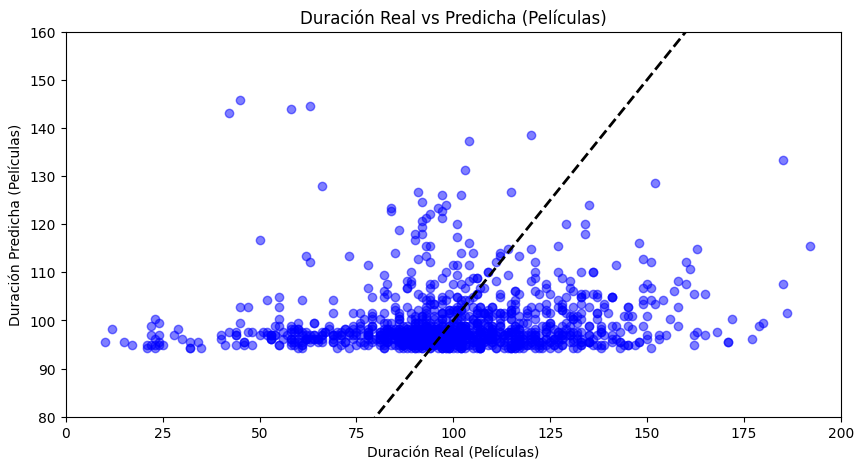

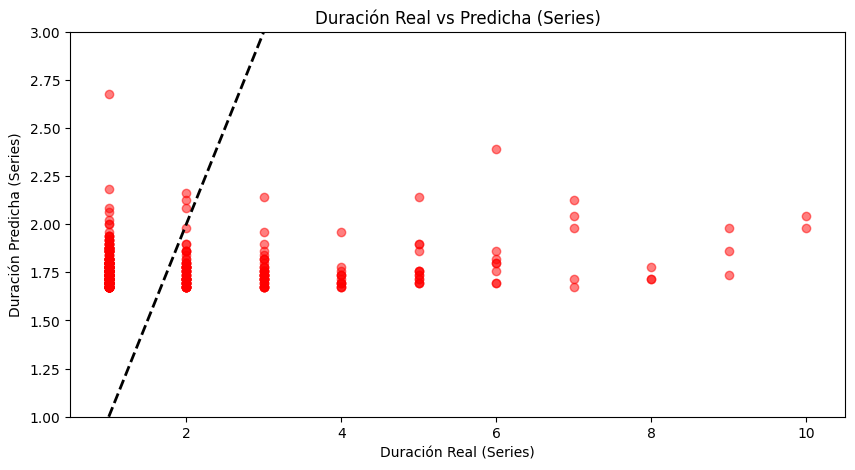

In [ ]:

# Mostrar resultados en tablas
results = pd.DataFrame({
    'Model': ['Movies', 'TV Shows'],
    'R²': [r2_movies, r2_tv_shows],
    'MSE': [mse_movies, mse_tv_shows]
})
print(results)

Revisar_Propiedades_Residuos(residuos_movies,X_test_movies)

Revisar_Propiedades_Residuos(residuos_tv_shows,X_test_tv_shows)

def mostrar_grafo_iniciales():
    # Gráfico de dispersión para películas
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_movies, y_pred_movies, color='blue', alpha=0.5)
    plt.plot([y_test_movies.min(), y_test_movies.max()], [y_test_movies.min(), y_test_movies.max()], 'k--', lw=2)
    plt.xlabel('Duración Real (Películas)')
    plt.ylabel('Duración Predicha (Películas)')
    plt.title('Duración Real vs Predicha (Películas)')
    plt.xlim(0, 200)  # Establecer límites del eje x
    plt.ylim(80, 160)  # Establecer límites del eje y
    plt.show()

    # Gráfico de dispersión para series
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_tv_shows, y_pred_tv_shows, color='red', alpha=0.5)
    plt.plot([y_test_tv_shows.min(), y_test_tv_shows.max()], [y_test_tv_shows.min(), y_test_tv_shows.max()], 'k--', lw=2)
    plt.xlabel('Duración Real (Series)')
    plt.ylabel('Duración Predicha (Series)')
    plt.title('Duración Real vs Predicha (Series)')
    plt.xlim(0.5, 10.5)  # Establecer límites del eje x
    plt.ylim(1, 3)  # Establecer límites del eje y
    plt.show()

mostrar_grafo_iniciales()

# Propuestas y aplicación de mejoras

## Aplicación de Mejoras con Ridge y Lasso

### Explicación

Se aplican técnicas de regularización Ridge y Lasso para mejorar los modelos de regresión lineal tanto para películas como para series. Se ajustan los modelos Ridge y Lasso utilizando los datos de entrenamiento y se realizan predicciones en los datos de prueba. Luego, se evalúan los modelos mejorados utilizando las métricas R² y MSE.


In [ ]:

# Aplicar Ridge y Lasso para películas

ridge_movies = Ridge(alpha=1.0)
y_pred_ridge_movies,r2_ridge_movies,mse_ridge_movies,residuos_ridge_movies= FunctionRegresion( ridge_movies,
                                                                                               X_train_movies,
                                                                                               X_test_movies,
                                                                                               y_train_movies,
                                                                                               y_test_movies)

lasso_movies = Lasso(alpha=0.1)
y_pred_lasso_movies,r2_lasso_movies,mse_lasso_movies,residuos_lasso_movies = FunctionRegresion( lasso_movies,
                                                                                                X_train_movies,
                                                                                                X_test_movies,
                                                                                                y_train_movies,
                                                                                                y_test_movies)

# Aplicar Ridge y Lasso para series

ridge_tv_shows = Ridge(alpha=1.0)
y_pred_ridge_tv_shows,r2_ridge_tv_shows,mse_ridge_tv_shows,residuos_ridge_tv_shows = FunctionRegresion( ridge_tv_shows,
                                                                                                        X_train_tv_shows,
                                                                                                        X_test_tv_shows,
                                                                                                        y_train_tv_shows,
                                                                                                        y_test_tv_shows)

lasso_tv_shows = Lasso(alpha=0.1)
y_pred_lasso_tv_shows,r2_lasso_tv_shows,mse_lasso_tv_shows,residuos_lasso_tv_shows = FunctionRegresion( lasso_tv_shows,
                                                                                                        X_train_tv_shows,
                                                                                                        X_test_tv_shows,
                                                                                                        y_train_tv_shows,
                                                                                                        y_test_tv_shows)

## Resultados Mejorados

### Explicación

Se muestran los resultados mejorados de los modelos de regresión lineal con Ridge y Lasso en una tabla, incluyendo las métricas R² y MSE para películas y series.Tambien se presentan grafo que muestra la comparación de los modelos de regresión lineal con Ridge y Lasso , incluyendo las métricas R² y MSE para películas y series.


In [215]:

# Mostrar resultados mejorados en tablas
improved_results_Movies = pd.DataFrame({
    'Movie Model': ['R²_Score', 'MS_Error'],
    'Original': [r2_movies, mse_movies],
    'Ridge': [r2_ridge_movies,mse_ridge_movies],
    'Lasso': [r2_lasso_movies, mse_lasso_movies],
    })
print(improved_results_Movies)
print('\n')

Revisar_Propiedades_Residuos(residuos_ridge_movies,X_test_movies)
Revisar_Propiedades_Residuos(residuos_lasso_movies,X_test_movies)


  Movie Model    Original       Ridge       Lasso
0    R²_Score    0.006001    0.006001    0.006083
1    MS_Error  703.664972  703.664894  703.606734




Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
La media de los residuos tiene un problema significativo (0.5 - 1)
Hay evidencia de heteroscedasticidad (No Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)




Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
La media de los residuos tiene un problema significativo (0.5 - 1)
Hay evidencia de heteroscedasticidad (No Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)




In [216]:

improved_results_tv_shows = pd.DataFrame({ 
    'TV Shows Model':['R²_Score', 'MS_Error'],
    'Original': [r2_tv_shows, mse_tv_shows],
    'Ridge': [r2_ridge_tv_shows, mse_ridge_tv_shows],
    'Lasso': [r2_lasso_tv_shows, mse_lasso_tv_shows],
})
print(improved_results_tv_shows)

Revisar_Propiedades_Residuos(residuos_ridge_tv_shows,X_test_tv_shows)
Revisar_Propiedades_Residuos(residuos_lasso_tv_shows,X_test_tv_shows)


  TV Shows Model  Original     Ridge     Lasso
0       R²_Score  0.014209  0.014209  0.012650
1       MS_Error  2.741052  2.741052  2.745388


Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
  La media de los residuos es aceptable (0 ± 0.1)
Hay evidencia de heteroscedasticidad (No Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)




Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
  La media de los residuos es aceptable (0 ± 0.1)
Hay evidencia de heteroscedasticidad (No Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)




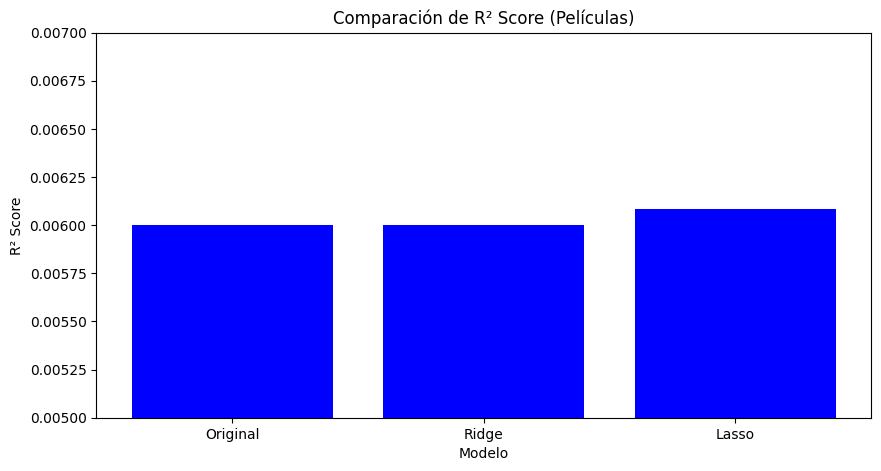

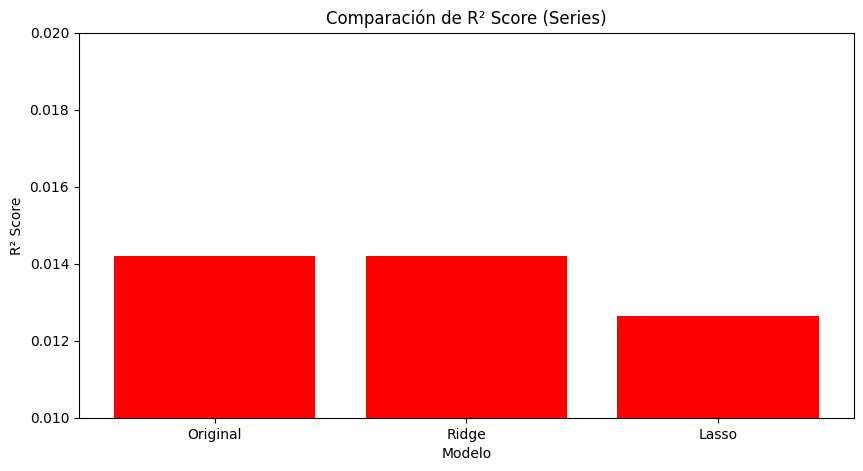

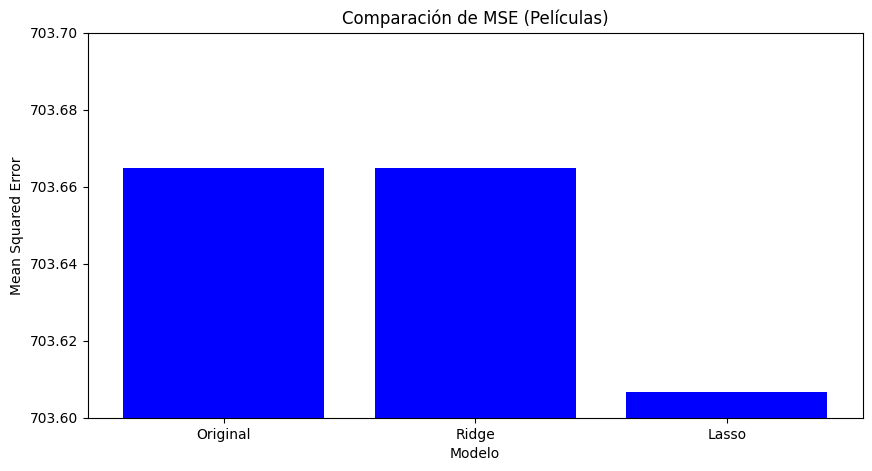

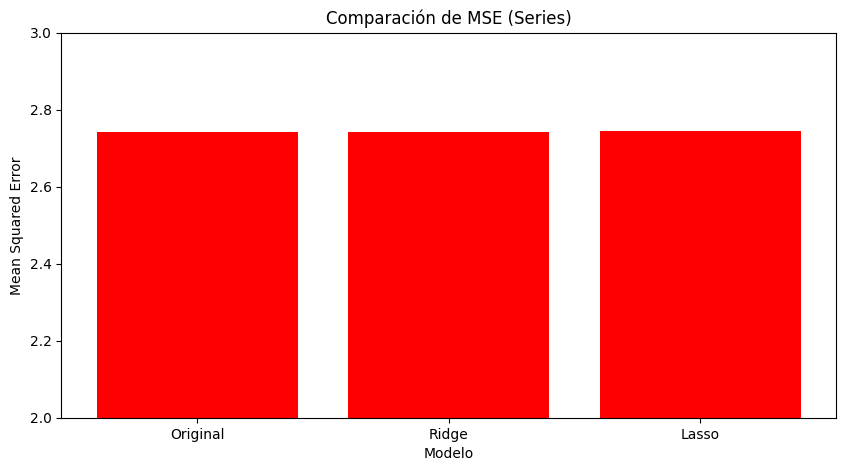

: 

In [ ]:

def Mostrar_graficas():
    # Grafico de comparación de R² Score entre los modelos originales y los modelos Ridge y Lasso
    plt.figure(figsize=(10, 5))
    plt.bar(['Original', 'Ridge', 'Lasso'], [r2_movies, r2_ridge_movies, r2_lasso_movies], color='blue')
    plt.xlabel('Modelo')
    plt.ylabel('R² Score')
    plt.title('Comparación de R² Score (Películas)')
    plt.ylim(0.005, 0.007)  # Establecer límites del eje y
    plt.show()
    # Grafico de comparación de R² Score entre los modelos originales y los modelos Ridge y Lasso
    plt.figure(figsize=(10, 5))
    plt.bar(['Original', 'Ridge', 'Lasso'], [r2_tv_shows, r2_ridge_tv_shows, r2_lasso_tv_shows], color='red')
    plt.xlabel('Modelo')
    plt.ylabel('R² Score')
    plt.title('Comparación de R² Score (Series)')
    plt.ylim(0.01, 0.02)  # Establecer límites del eje y
    plt.show()

    # Grafico de comparación de MSE entre los modelos originales y los modelos Ridge y Lasso
    plt.figure(figsize=(10, 5))
    plt.bar(['Original', 'Ridge', 'Lasso'], [mse_movies, mse_ridge_movies, mse_lasso_movies], color='blue')
    plt.xlabel('Modelo')
    plt.ylabel('Mean Squared Error')
    plt.title('Comparación de MSE (Películas)')
    plt.ylim(703.6, 703.7)  # Establecer límites del eje y
    plt.show()
    # Grafico de comparación de MSE entre los modelos originales y los modelos Ridge y Lasso
    plt.figure(figsize=(10, 5))
    plt.bar(['Original', 'Ridge', 'Lasso'], [mse_tv_shows, mse_ridge_tv_shows, mse_lasso_tv_shows], color='red')
    plt.xlabel('Modelo')
    plt.ylabel('Mean Squared Error')
    plt.title('Comparación de MSE (Series)')
    plt.ylim(2,3)  # Establecer límites del eje y
    plt.show()

Mostrar_graficas()

1. **Conclusiones**:
   - La regresión lineal básica muestra una relación entre el año de lanzamiento, el género y el director con la duración, pero no es muy fuerte.
   - Las técnicas de regularización como Ridge y Lasso mejoran la predicción, reduciendo el error y aumentando el R².
   - Se pueden explorar más variables independientes para mejorar aún más el modelo, como el género o la calificación.

2. **Predicciones**:
   - Con los modelos mejorados, se pueden hacer predicciones más precisas sobre la duración de nuevas películas y series basadas en su año de lanzamiento y otras características relevantes.


# Otros Ejemplos de regresion Lineal a Peliculas

## 1. Regresión Lineal para Predecir la Duración
### Hipótesis: 
La duración de una película/serie podría relacionarse con su género, director, clasificación por edades y año de estreno.


In [ ]:

# Definir variables
X_duration = movies[['listed_in', 'director', 'rating', 'release_year']]
y_duration = movies['duration']
# Codificar variables categóricas
preprocessor_duration = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['listed_in', 'director', 'rating'])
    ],
    remainder='passthrough'
)

# Dividir datos
X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(X_duration, y_duration, test_size=0.2, random_state=42)

# Aplicar preprocesamiento
X_train_dur_processed = preprocessor_duration.fit_transform(X_train_dur)
X_test_dur_processed = preprocessor_duration.transform(X_test_dur)

# Entrenar modelo
model_duration = LinearRegression()
y_pred_dur,r2_dur,mse_dur,residuos_dur= FunctionRegresion( model_duration,
                                                           X_train_dur_processed,
                                                           X_test_dur_processed,
                                                           y_train_dur,
                                                           y_test_dur)

print(f"Predicción de Duración - R²: {r2_dur}")
print(f"Predicción de Duración - MAE: {mean_absolute_error(y_test_dur, y_pred_dur):.2f} minutos")

Revisar_Propiedades_Residuos(residuos_dur,X_test_dur_processed)



## Evaluación y optimización
 La regresión lineal básica muestra una relación débil entre las variables independientes y la duración (R² bajo).
## Propuesta: 
Aplicar Ridge y Lasso para mejorar la predicción.


In [ ]:
ridge_duration = Ridge(alpha=1.0)
y_pred_ridge_dur,r2_ridge_dur,mse_ridge_dur,residuos_ridge_dur= FunctionRegresion( ridge_duration,
                                                                                   X_train_dur_processed,
                                                                                   X_test_dur_processed,
                                                                                   y_train_dur,
                                                                                   y_test_dur)

print(f"Predicción de Duración (Ridge) - R²: {r2_ridge_dur}")
print(f"Predicción de Duración (Ridge) - MAE: {mean_absolute_error(y_test_dur, y_pred_ridge_dur):.2f} minutos")

Revisar_Propiedades_Residuos(residuos_ridge_dur,X_test_dur_processed)

lasso_duration = Lasso(alpha=0.1)
y_pred_lasso_dur,r2_lasso_dur,mse_lasso_dur,residuos_lasso_dur= FunctionRegresion( lasso_duration,
                                                                                   X_train_dur_processed,
                                                                                   X_test_dur_processed,
                                                                                   y_train_dur,
                                                                                   y_test_dur)

print(f"Predicción de Duración (Lasso) - R²: {r2_lasso_dur}")
print(f"Predicción de Duración (Lasso) - MAE: {mean_absolute_error(y_test_dur, y_pred_lasso_dur):.2f} minutos")

Revisar_Propiedades_Residuos(residuos_lasso_dur,X_test_dur_processed)


## 2. Regresión Lineal para Predecir el Año de Estreno
### Hipótesis: 
El año de estreno podría correlacionarse con cambios en la clasificación por edades o géneros.


In [ ]:

# Definir variables
X_year = movies[['listed_in', 'rating', 'duration', 'director']]
y_year = movies['release_year']

# Codificar variables categóricas
preprocessor_year = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['listed_in', 'rating', 'director'])
    ],
    remainder='passthrough'
)

# Dividir datos
X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(X_year, y_year, test_size=0.2, random_state=42)

# Aplicar preprocesamiento
X_train_year_processed = preprocessor_year.fit_transform(X_train_year)
X_test_year_processed = preprocessor_year.transform(X_test_year)

# Entrenar modelo
model_year = LinearRegression()
y_pred_year,r2_year,mse_year,residuos_year= FunctionRegresion(model_year, 
                                                              X_train_year_processed, 
                                                              X_test_year_processed, 
                                                              y_train_year, 
                                                              y_test_year) 

print(f"Predicción de Año de Estreno - R²: {r2_year}")
print(f"Predicción de Año de Estreno - MAE: {mean_absolute_error(y_test_year, y_pred_year):.2f} años")

Revisar_Propiedades_Residuos(residuos_year,X_test_year_processed)


Predicción de Año de Estreno - R²: 0.4322877376968819
Predicción de Año de Estreno - MAE: 4.87 años


Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
La media de los residuos tiene un problema significativo (0.5 - 1)
 No hay evidencia de heteroscedasticidad (Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)


Predicción de Año de Estreno (Ridge) - R²: 0.48991262067010755
Predicción de Año de Estreno (Ridge) - MAE: 4.48 años


Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
La media de los residuos es posible que tenga un sesgo (0.1 - 0.5)
 No hay evidencia de heteroscedasticidad (Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)


Predicción de Año de Estreno (Lasso) - R²: 0.10870385363577095
Predicción de Año de Estreno (Lasso) - MAE: 5.69 años


Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
La media de los residuos es posible que tenga un sesgo


## Evaluación y optimización
La regresión lineal básica muestra una relación débil entre las variables independientes y el año de estreno (R² bajo).
## Propuesta: 
Aplicar Ridge y Lasso para mejorar la predicción.


In [213]:

ridge_year = Ridge(alpha=1.0)
y_pred_ridge_year,r2_ridge_year,mse_ridge_year,residuos_ridge_year= FunctionRegresion( ridge_year, 
                                                                                       X_train_year_processed, 
                                                                                       X_test_year_processed, 
                                                                                       y_train_year, 
                                                                                       y_test_year)

print(f"Predicción de Año de Estreno (Ridge) - R²: {r2_ridge_year}")
print(f"Predicción de Año de Estreno (Ridge) - MAE: {mean_absolute_error(y_test_year, y_pred_ridge_year):.2f} años")

Revisar_Propiedades_Residuos(residuos_ridge_year,X_test_year_processed)

lasso_year = Lasso(alpha=0.1)
y_pred_lasso_year,r2_lasso_year,mse_lasso_year,residuos_lasso_year= FunctionRegresion( lasso_year, 
                                                                                       X_train_year_processed, 
                                                                                       X_test_year_processed, 
                                                                                       y_train_year, 
                                                                                       y_test_year)

print(f"Predicción de Año de Estreno (Lasso) - R²: {r2_lasso_year}")
print(f"Predicción de Año de Estreno (Lasso) - MAE: {mean_absolute_error(y_test_year, y_pred_lasso_year):.2f} años")

Revisar_Propiedades_Residuos(residuos_lasso_year,X_test_year_processed)


Predicción de Año de Estreno (Ridge) - R²: 0.48991262067010755
Predicción de Año de Estreno (Ridge) - MAE: 4.48 años


Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
La media de los residuos es posible que tenga un sesgo (0.1 - 0.5)
 No hay evidencia de heteroscedasticidad (Homoscedasticidad)
  No hay evidencia de autocorrelación (Independencia)


Predicción de Año de Estreno (Lasso) - R²: 0.10870385363577095
Predicción de Año de Estreno (Lasso) - MAE: 5.69 años


Los residuos no siguen una distribución normal (Se rechaza la hipótesis nula)
La media de los residuos es posible que tenga un sesgo (0.1 - 0.5)
 No hay evidencia de heteroscedasticidad (Homoscedasticidad)
Hay evidencia de autocorrelación negativa (No independencia)





## Interpretación y Objetivo:
### 1. Predicción de Duración:
El objetivo es entender cómo el género, director, clasificación por edades y año de estreno influyen en la duración de películas/series. Las métricas R² y MAE ayudan a evaluar el rendimiento del modelo.
### 2. Predicción de Año de Estreno: 
Este modelo busca explorar la relación entre el año de estreno y otras características como el género y la clasificación por edades. Las métricas R² y MAE proporcionan información sobre la precisión del modelo.

